Philippe Joly 2025-06-07

# CHAIM Ionosphere Plasma Frequency Overview

This notebook is simply to llok over the A/E-CHAIM data and the critical plasma frequency across the observational times

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import sys
from os import path
sys.path.append(path.expanduser('~'))

## Load CHAIM Data

In [15]:
fn = "/project/rrg-sievers/philj0ly/CHAIM/CSV/ACHAIM_nmf2.csv"

achaim = pd.read_csv(fn)

obs_period = [1721342139, 1721449881] # Full observation period
obs_period = [1721342139, 1721376339] # First 'continuous' chunk of observation period
# obs_period = [1721376339, 1721449881]
   
achaim["datetime fmt"] = pd.to_datetime(achaim["datetime"], format="%y%m%d_%H%M%S")
achaim["datetime"] = achaim["datetime fmt"].astype('int')//10**9
achaim = achaim[(achaim['datetime'] >= obs_period[0]) & (achaim['datetime'] <= obs_period[1])].copy()
achaim = achaim.sort_values(by='datetime')
t_diff = 5*60

print(f"Loaded {len(achaim)} Data points from {obs_period[0]} to {obs_period[1]}")

Loaded 89 Data points from 1721342139 to 1721376339


In [17]:
achaim.head()

,datetime,nmf2,datetime fmt
283,1721342250,5.649413e+11,2024-07-18 22:37:30
284,1721342550,5.580359e+11,2024-07-18 22:42:30
285,1721342850,5.680701e+11,2024-07-18 22:47:30
286,1721343150,5.594022e+11,2024-07-18 22:52:30
287,1721343450,5.459377e+11,2024-07-18 22:57:30


In [11]:
eps = 8.8541878188 * 1e-12 # vacuum electric permittivity  [ F / m]
m_e = 9.1093837139 * 1e-31 # electron mass [ kg ]
e = 1.602176634  * 1e-19 # electron charge [ C ]

def get_plasma_freq(nmf2):
    w_p = np.sqrt( nmf2 * e**2 / (m_e * eps) )
    return w_p / (2*np.pi)

achaim["plasma_freq"] = get_plasma_freq(achaim["nmf2"])

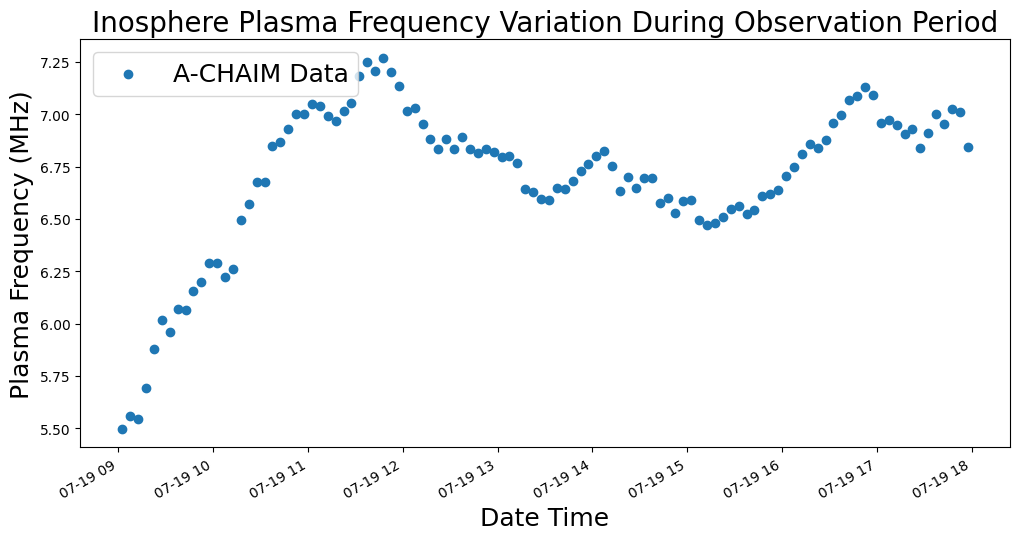

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(achaim["datetime fmt"], achaim["plasma_freq"]*1e-6, label="A-CHAIM Data")

plt.gcf().autofmt_xdate()

plt.title("Inosphere Plasma Frequency Variation During Observation Period", fontsize=20)
plt.xlabel("Date Time", fontsize=18)
plt.ylabel("Plasma Frequency (MHz)", fontsize=18)
plt.legend(fontsize=18)
plt.show()    

Looking at the full observational period we see that the max value is ~ 8.2 MHz and the lowest ~ 4.25 MHz. Note that there are significant gaps in the data.

Looking at the first continuous chunk we have variation between ~7 MHz and ~4.5 MHz.

## Binning 

In [5]:
plasma = achaim["plasma_freq"].to_numpy()
time = achaim["datetime"].to_numpy()

bin_num = 20  

counts, bin_edges = np.histogram(plasma, bins=bin_num)

bin_indices = np.digitize(plasma, bin_edges)

binned_data = {}
for i in range(1, bin_num + 1):
    binned_data[i] = time[bin_indices == i]

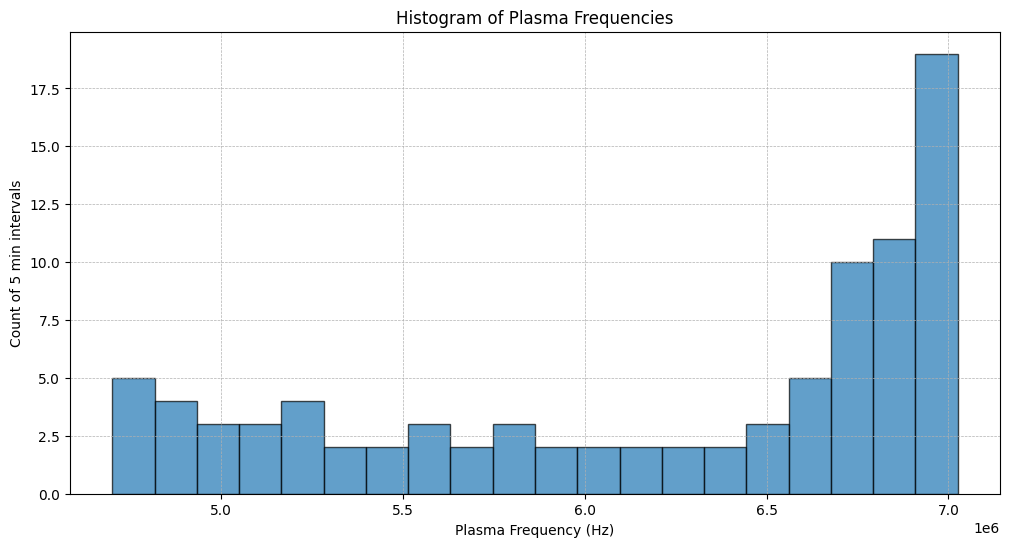

In [131]:
plt.figure(figsize=(12, 6))
plt.hist(plasma, bins=bin_num, edgecolor='black', alpha=0.7)
plt.title('Histogram of Plasma Frequencies')
plt.xlabel('Plasma Frequency (Hz)')
plt.ylabel('Count of 5 min intervals')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [132]:
binned_time = {}

for i in binned_data:
    times_out = []
    timestamps = np.sort(binned_data[i])

    for t in timestamps:
        if len(times_out) != 0 and t == times_out[-1][-1]:
            times_out[-1][-1] += t_diff
        else:
            times_out.append([t, t+t_diff])

    binned_time[i] = (binned_data[i].shape[0]*t_diff, times_out)   

In [80]:
# This would be to plot in case of uneven time splits
# bin_centers = bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2
# bulk_data = []
# for b in range(bin_centers.shape[0]):
#     for j in range(binned_time[b+1][0]):
#         bulk_data.append(bin_centers[b])
# bulk_data = np.array(bulk_data)

# plt.figure(figsize=(12, 6))
# plt.hist(bulk_data, bins=bin_num, edgecolor='black', alpha=0.7)
# plt.title('Histogram of Plasma Frequencies')
# plt.xlabel('Plasma Frequency (Hz)')
# plt.ylabel('Seconds')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.show()

## Visibility Array Extraction

In [165]:
# An Inplace array designed to mimick the shape of ALBATROS data (~1 Hz) (stoke's parameter I)
osamp = 2**16 # rechannelization factor for ~1Hz
df_record = 125e6/2048 # (Hz) frequency range / # of channels
df = df_record/osamp # (Hz) 

sr = 250e6
pfb_acclen = 4*osamp # nblock*osamp
t_step = pfb_acclen/sr

chans = [65, 180] # Hz (+1 since 0 index in data)
bw = (chans[1]-chans[0])*df_record

n_f = int(bw//df)
n_t = int((np.max(time)-np.min(time))/t_step +3)


#prop n_f for testing purposes
n_f = 115 # ~ 61 kHz

data = np.zeros((n_f,n_t), dtype="float32")
t_start = np.min(time)-t_step # start of PFBed Data

data[0] = np.arange(n_t, dtype="float32")

In [157]:
avg_data = {}

for i in binned_time:
    summer = np.zeros_like(data[:,0])
    for interval in binned_time[i][1]:
        init_idx = int((interval[0]-t_start)//t_step)
        end_idx = int(np.ceil((interval[1]-t_start)//t_step))
        summer += np.sum(data[:, init_idx:end_idx+1], axis=1)

    avg_data[i] = summer / (binned_time[i][0] / t_diff)

In [172]:
for i in avg_data:
    print(i, 30*'-')
    print(binned_time[i])
    print('result (1st channel)', avg_data[i][0])

    if i>5:
        print('...')
        break

1 ------------------------------
(1500, [[np.int64(1721367450), np.int64(1721368950)]])
result (1st channel) 5631596600000.0
2 ------------------------------
(1200, [[np.int64(1721366250), np.int64(1721367450)]])
result (1st channel) 6712077600000.0
3 ------------------------------
(900, [[np.int64(1721365350), np.int64(1721366250)]])
result (1st channel) 6425582000000.0
4 ------------------------------
(900, [[np.int64(1721364450), np.int64(1721365350)]])
result (1st channel) 6180026400000.0
5 ------------------------------
(1200, [[np.int64(1721363250), np.int64(1721364450)]])
result (1st channel) 5893524600000.0
6 ------------------------------
(600, [[np.int64(1721362650), np.int64(1721363250)]])
result (1st channel) 5647968500000.0
...
